In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import itertools
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import sys
sys.path.append('../')
import utils
import settings

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path='../')
X_reshaped_train_estimated_a, X_reshaped_train_estimated_b, X_reshaped_train_estimated_c, X_reshaped_train_observed_a, X_reshaped_train_observed_b, X_reshaped_train_observed_c, X_reshaped_test_estimated_a, X_reshaped_test_estimated_b, X_reshaped_test_estimated_c = utils.get_reshaped_files(diff_path='../')

In [3]:
train_a_copy = train_a.copy()

In [4]:
train_a_copy.set_index('time', inplace=True)
max_values_per_day = train_a_copy.resample('D').max()
max_values_per_day

,pv_measurement
time,
2019-06-02,0.00
2019-06-03,3175.92
2019-06-04,4812.06
2019-06-05,3044.80
2019-06-06,989.78
...,...
2023-04-26,2822.16
2023-04-27,1266.76
2023-04-28,4581.50


In [5]:
train_a_daily = train_a[train_a['time'].dt.strftime('%H:%M:%S').str.endswith('12:00:00')]
train_a_daily

,time,pv_measurement
14,2019-06-03 12:00:00,3175.92
38,2019-06-04 12:00:00,2464.00
62,2019-06-05 12:00:00,1572.56
86,2019-06-06 12:00:00,0.00
110,2019-06-07 12:00:00,423.94
...,...,...
33977,2023-04-26 12:00:00,2369.18
34001,2023-04-27 12:00:00,886.82
34025,2023-04-28 12:00:00,1467.40
34049,2023-04-29 12:00:00,1410.42


In [6]:
# train_a_daily_max = train_a[]

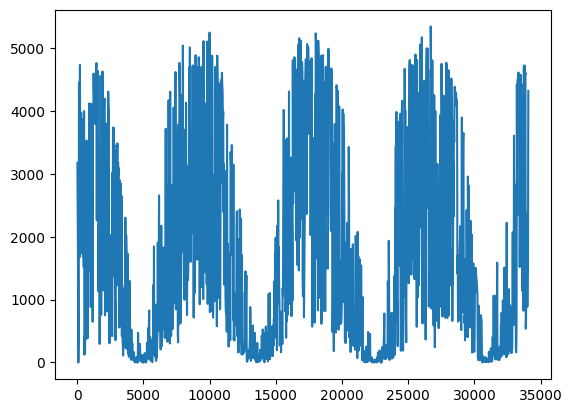

In [7]:
plt.plot(train_a_daily['pv_measurement'])

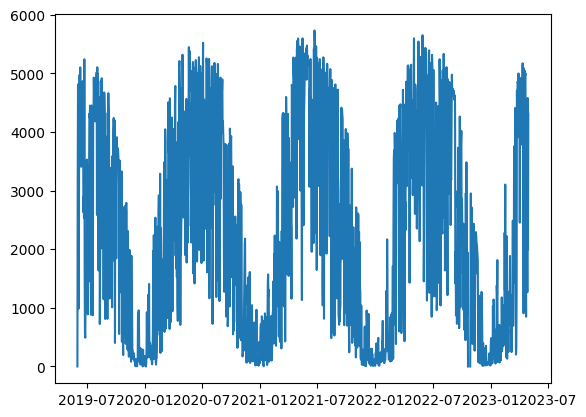

In [8]:
plt.plot(max_values_per_day['pv_measurement'])

In [9]:
train_a = train_a.rename(columns={'time': 'ds', 'pv_measurement': 'y'})[:29667] # 29667
train_a["y"] = (train_a["y"] - train_a["y"].mean()) / train_a["y"].std()
# train_a["y"] /= train_a["y"].max()

In [10]:
train_a_daily = train_a_daily.rename(columns={'time': 'ds', 'pv_measurement': 'y'})[:29667] # 29667
train_a_daily["y"] = (train_a_daily["y"] - train_a_daily["y"].mean()) / train_a_daily["y"].std()
# train_a["y"] /= train_a["y"].max()

In [11]:
max_values_per_day = max_values_per_day.reset_index()

In [12]:
max_values_per_day = max_values_per_day.rename(columns={'time': 'ds', 'pv_measurement': 'y'})[:29667] # 29667
max_values_per_day["y"] = (max_values_per_day["y"] - max_values_per_day["y"].mean()) / max_values_per_day["y"].std()
max_values_per_day

,ds,y
0,2019-06-02,-1.314747
1,2019-06-03,0.462919
2,2019-06-04,1.378720
3,2019-06-05,0.389527
4,2019-06-06,-0.760735
...,...,...
1424,2023-04-26,0.264908
1425,2023-04-27,-0.605700
1426,2023-04-28,1.249668
1427,2023-04-29,-0.198718


In [13]:
m = Prophet(changepoint_prior_scale=0.05)
m.fit(train_a)

16:20:23 - cmdstanpy - INFO - Chain [1] start processing
16:20:27 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
m = Prophet(changepoint_prior_scale=0.05)
m.fit(train_a_daily)

16:20:27 - cmdstanpy - INFO - Chain [1] start processing
16:20:27 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# future = m.make_future_dataframe(periods=66 * 24, freq='D')
future = m.make_future_dataframe(periods=66, freq='D')
future.tail()

,ds
1481,2023-07-01 12:00:00
1482,2023-07-02 12:00:00
1483,2023-07-03 12:00:00
1484,2023-07-04 12:00:00
1485,2023-07-05 12:00:00


In [16]:
forecast = m.predict(future)
forecast[['yhat']].tail()

,yhat
1481,1.544094
1482,1.951330
1483,0.842841
1484,0.529817
1485,-0.114174


/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


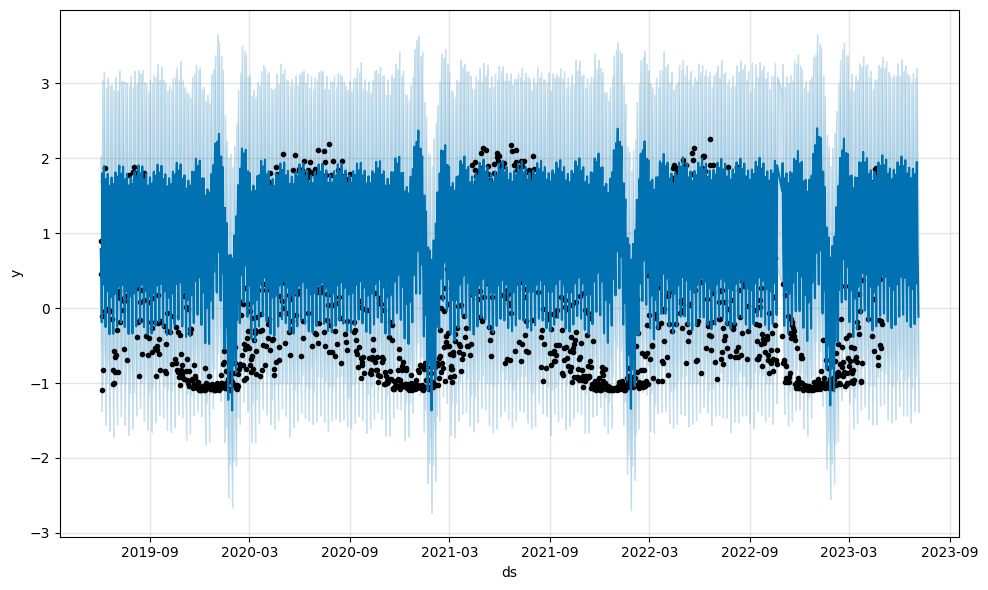

In [17]:
fig1 = m.plot(forecast) 

In [18]:
forecast[forecast['ds'] >= '2023-05-01'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1481,2023-07-01 12:00:00,1.544094,0.276133,2.865529
1482,2023-07-02 12:00:00,1.951330,0.733105,3.207408
1483,2023-07-03 12:00:00,0.842841,-0.416897,2.108522
1484,2023-07-04 12:00:00,0.529817,-0.736905,1.871250
1485,2023-07-05 12:00:00,-0.114174,-1.387826,1.145060


In [19]:
forecast['yhat']

0       0.789190
1       0.466369
2      -0.188913
3       1.800367
4       0.310687
          ...   
1481    1.544094
1482    1.951330
1483    0.842841
1484    0.529817
1485   -0.114174
Name: yhat, Length: 1486, dtype: float64

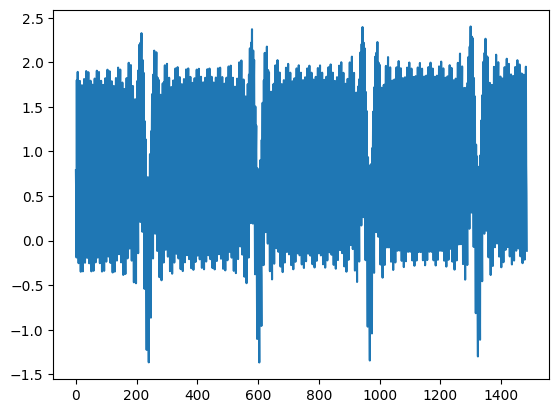

In [20]:
plt.plot(forecast['yhat'])

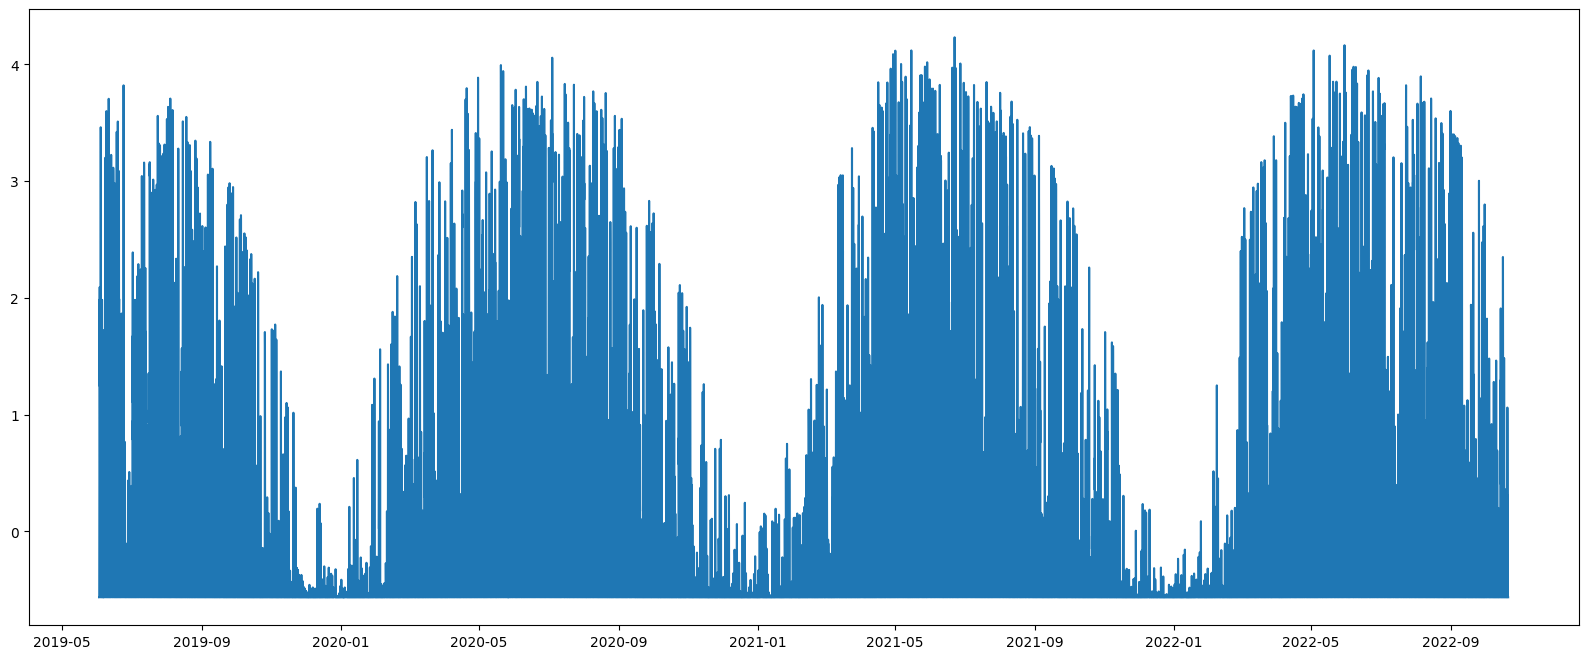

In [21]:
plt.figure(figsize=(20, 8))
plt.plot(train_a["ds"], train_a["y"])

In [22]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
df = max_values_per_day
print(all_params)
# Use cross validation to evaluate all parameters
for params in all_params:
    print('params:', params)
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    # df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

16:20:28 - cmdstanpy - INFO - Chain [1] start processing
16:20:28 - cmdstanpy - INFO - Chain [1] done processing
16:20:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:20:28 - cmdstanpy - INFO - Chain [1] start processing


[{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}, {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 

16:20:29 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
16:20:30 - cmdstanpy - INFO - Chain [1] start processing
16:20:30 - cmdstanpy - INFO - Chain [1] done processing
16:20:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:20:30 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:20:30 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:20:31 - cmdstanpy - INFO - Chain [1] done processing
16:20:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
1

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


16:20:38 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:20:39 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
16:20:39 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
16:20:39 - cmdstanpy - INFO - Chain [1] done processing
16:20:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:20:39 - cmdstanpy - INFO - Chain [1] start processing
16:20:39 - cmdstanpy - INFO - Chain [1] done processing
16:20:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:20:39 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
16

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive'}


16:20:48 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
16:20:49 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
16:20:49 - cmdstanpy - INFO - Chain [1] done processing
16:20:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:20:49 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:20:49 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
16:20:49 - cmdstanpy - INFO - Chain [1] start processing
16:20:49 - cmdstanpy - INFO - Chain [1] start processing
16:20:49 - cmdstanpy - INFO - Chain [1] d

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


16:20:56 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:20:57 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
16:20:57 - cmdstanpy - INFO - Chain [1] done processing
16:20:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
16:20:57 - cmdstanpy - INFO - Chain [1] start processing
16:20:57 - cmdstanpy - INFO - Chain [1] start processing
16:20:57 - cmdstanpy - INFO - Chain [1] start processing
16:20:57 - cmdstanpy - INFO - Chain [1] done processing
16:20:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
Im

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}


16:21:07 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:21:09 - cmdstanpy - INFO - Chain [1] start processing
16:21:09 - cmdstanpy - INFO - Chain [1] done processing
16:21:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
16:21:09 - cmdstanpy - INFO - Chain [1] start processing
16:21:09 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:21:09 - cmdstanpy - INFO - Chain [1] done processing
16:21:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:09 - cmdstanpy - INFO - Chain [1] start processing
Im

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


16:21:17 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:21:18 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
16:21:18 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
16:21:18 - cmdstanpy - INFO - Chain [1] start processing
16:21:18 - cmdstanpy - INFO - Chain [1] done processing
16:21:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:18 - cmdstanpy - INFO - Chain [1] done processing
16:21:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
1

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}


16:21:31 - cmdstanpy - INFO - Chain [1] start processing
16:21:32 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
16:21:33 - cmdstanpy - INFO - Chain [1] start processing
16:21:33 - cmdstanpy - INFO - Chain [1] done processing
16:21:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:33 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:21:33 - cmdstanpy - INFO - Chain [1] start processing
16:21:33 - cmdstanpy - INFO - Chain [1] start processing
16:21:33 - cmdstanpy - INFO - Chain [1] start processing
16:21:33 - cmdstanpy - INFO - Chain [1] done processing
16:21:33 - cmdstanpy - ERROR - Chain [1] err

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


16:21:40 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:21:41 - cmdstanpy - INFO - Chain [1] start processing
16:21:41 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
16:21:41 - cmdstanpy - INFO - Chain [1] done processing
16:21:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Importing plotly failed. Interactive plots will not work.
Optimization terminated abnormally. Falling back to Newton.
16:21:41 - cmdstanpy - INFO - Chain [1] start processing
16:21:41 - cmdstanpy - INFO - Chain [1] done processing
16:21:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opt

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


16:21:51 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:21:52 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Importing plotly failed. Interactive plots will not work.
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
16:21:53 - cmdstanpy - INFO - Chain [1] start processing
16:21:53 - cmdstanpy - INFO - Chain [1] done processing
16:21:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opt

params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


KeyboardInterrupt: 

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

In [ ]:
m = Prophet(**best_params)
m.fit(max_values_per_day)
future = m.make_future_dataframe(periods=66, freq='H')
fig1 = m.plot(forecast)